In [126]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from ipywidgets import interact

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

from observations import iris, mnist
DATA_DIR = './data'

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

print('Tensorflow Probability version: ', tf.__version__)

seed = 2018
np.random.seed(seed)
tf.set_random_seed(seed)

Tensorflow Probability version:  1.10.0-dev20180716


In [20]:
# (x_train, y_train), (x_test, y_test) = mnist(DATA_DIR)
(x_train, y_train), (x_test, y_test) = mnist(DATA_DIR)
N = 2666
x_train = x_train[:N].T
y_class = y_train[:N]
print(x_train.shape, y_class.shape)

(784, 2666) (2666,)


In [119]:
x_train, y_train, metadata = iris(DATA_DIR)

# standardize data
# x_mean = np.mean(x_train, axis=0)
# x_std = np.std(x_train, axis=0)
# x_train = (x_train - x_mean) / x_std

x_train = x_train.T
y_label = np.unique(y_train)
y_dict = dict((label, i) for i, label in enumerate(y_label))
y_class = list(map(lambda label: y_dict[label], y_train))

In [131]:
data_dim, num_datapoints = x_train.shape
latent_dim = 2
stddev_datapoints = 2.0
stddev_w = 1.0

+ Marginal distribution of each data point:**

\begin{equation*}
\mathbf{x}_n \sim \mathcal{N}(\mathbf{0}, \mathbf{W} \mathbf{W}^T + \sigma^2 \mathbf{I})
\end{equation*}

+ Create a model as follow:
    * $\mathbf{z}_n \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$
    * $\mathbf{W} \sim \mathcal{N}(\mathbf{0}, 2 \mathbf{I})$
    * $\mathbf{x}_n | \mathbf{z}_n \sim \mathcal{N}(
        \mathbf{W} \mathbf{z}_n, \sigma^2 \mathbf{I} 
      )$


In [132]:
def ppca_model(data_dim, latent_dim, num_datapoints, stddev_datapoints, stddev_w=1):
    w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                  scale=stddev_w * tf.ones([data_dim, latent_dim]),
                  name="w") # parameter
    z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                  scale=tf.ones([latent_dim, num_datapoints]),
                  name="z") # parameter
    x = ed.Normal(loc=tf.matmul(w, z),
                  scale=stddev_datapoints * tf.ones([data_dim, num_datapoints]),
                  name="x") # modeled (observed) data
    return x, (w, z)
log_joint = ed.make_log_joint_fn(ppca_model)

### MAP: Maximum A Posterior Inference

+ **Goal**: find the point estimate of laten variables that maximizes the posterior probability density (maximum a posterior inference).
+ **Note**: The point-estimate methods find the exact values for each latent var. The variational methods find the probability distribution of the value of each latent var.
+ **How**: Calculating the values of $\mathbf{W}$ and $\mathbf{Z}$ that maxmize the posterior density: $p(\mathbf{W}, \mathbf{Z} | \mathbf{X})\propto p(\mathbf{W}, \mathbf{Z}, \mathbf{X})$.
Note that the `log_joint` function created by `ed.make_log_joint_fn` will represent for the log of the joint distribution of all variables in the model.

In [156]:
# what we actually want to find is `w` and `z`
# we have had their asumption "prior" values.
# we need to use the observed data `x` to do inference:
# that means, to transfer the prior to the posterior
# and the final expected results will be in `w_inferred_map` and `z_inferred_map`

def train_map(noise, std_w):
    tf.reset_default_graph()
    
    # first, define `w` and `z` as variable in the model
    w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
    z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
    
    # second, define a target function, which is an "unnormalized target density".
    # as a function of the parameters `w`, `z`
    # Note that we want to maximize the posterior distr.
    # which is proportional to the joint distribution of the model
    # -> the target function to maximize is exactly the joint distr. function
    def target(w, z):
        return log_joint(data_dim=data_dim,
                  latent_dim=latent_dim,
                  num_datapoints=num_datapoints,
                  stddev_datapoints=noise,
                  stddev_w=std_w,
                  w=w, z=z, x=x_train)
    
    # third, define the "energy function", which is the opposite of target function
    # we will use the off-the-shelf optimization module which minimize an objective function
    # that's why we conver the maximization prob. to mizimization one
    energy = - target(w, z)

    optimizer = tf.train.AdamOptimizer(learning_rate=0.05)
    train = optimizer.minimize(energy)
    
    # Learning params === Infering
    init = tf.global_variables_initializer()
    losses = []
    traceZ = []
    num_epochs = 1500

    with tf.Session() as sess:
        sess.run(init)
        for i in range(num_epochs):
            sess.run(train)
            if i % 10 == 0:
                cE, z_map = sess.run([energy, z])
                losses.append(cE)
                traceZ.append(z_map)
                

        # when finishing the training, get the learned values of the variables
        w_map = sess.run(w)
        z_map = sess.run(z)
    
    return losses, w_map, z_map, traceZ

In [157]:
@interact(noise=(1e-5, 2.0), std_w=(1e-5, 2.0))
def ppca_map(noise, std_w):
    losses, w_map, z_map, traceZ = train_map(noise, std_w)
    plt.plot(range(len(losses)), losses)
    plt.show()
    plt.scatter(z_map[0, :], z_map[1, :], c=y_class)
    plt.matshow(w_inferred_map.T, cmap='viridis')
    plt.show()

interactive(children=(FloatSlider(value=1.000005, description='noise', max=2.0, min=1e-05), FloatSlider(value=…

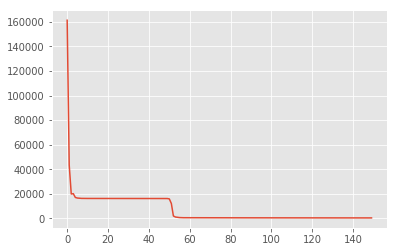

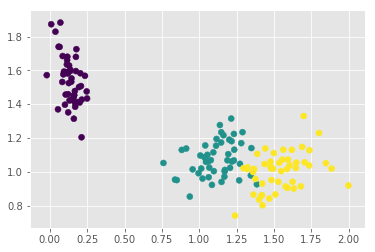

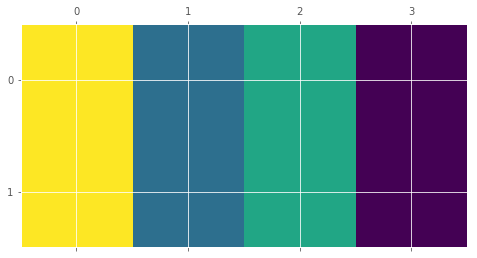

In [185]:
losses, w_map, z_map, traceZ = train_map(noise=0.1, std_w=1.0)
plt.plot(range(len(losses)), losses)
plt.show()
plt.scatter(z_map[0, :], z_map[1, :], c=y_class)
plt.matshow(w_inferred_map.T, cmap='viridis')
plt.show()

In [187]:
print(len(traceZ))

150


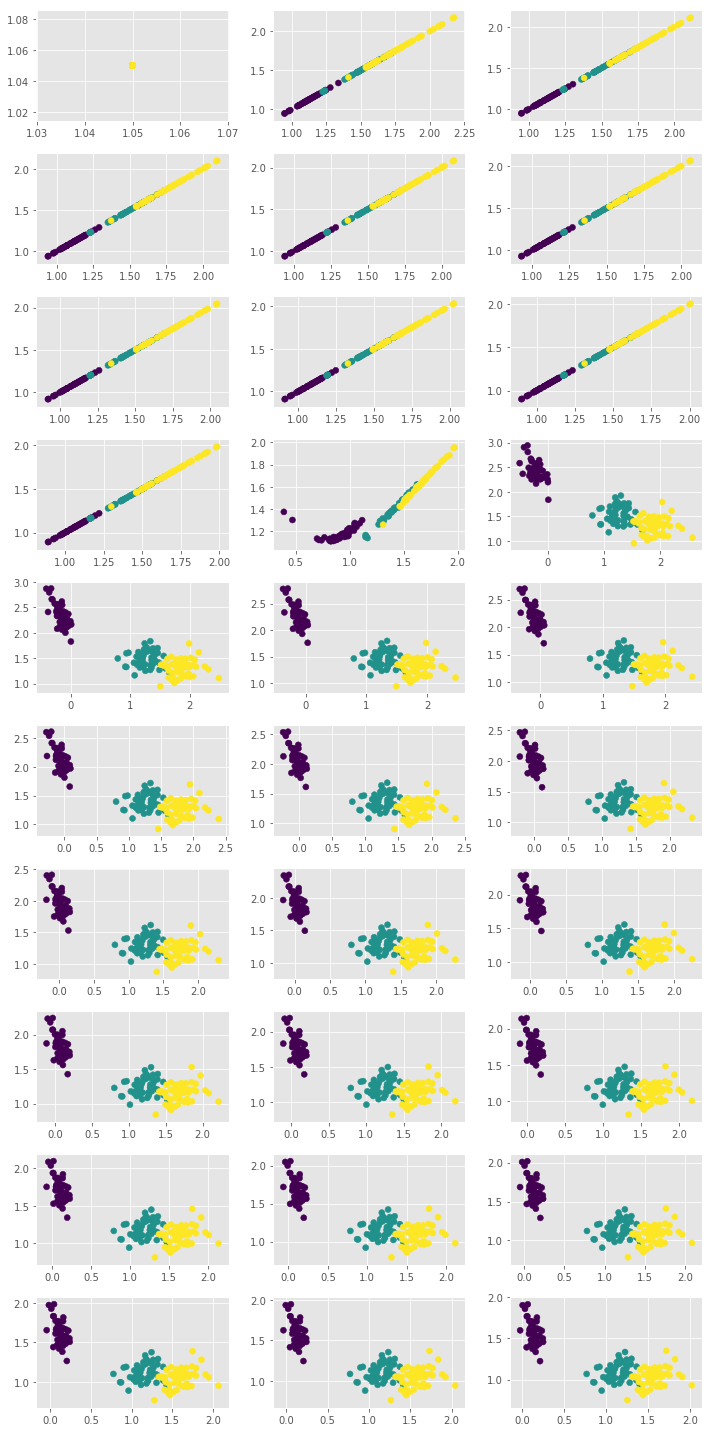

In [188]:
# 150 traces

fig, axes = plt.subplots(10,3, figsize=(10,20))
ax = axes.ravel()

for i in range(30):
    z_map = traceZ[i*5]
    ax[i].scatter(z_map[0, :], z_map[1, :], c=y_class)
    
plt.tight_layout()

### Model criticism

In [16]:
# using Edward2 model to sample data from inferred values of W and Z

def replace_latents(w=actual_w, z=actual_z):
    def interceptor(rv_constructor, *rv_args, **rv_kwargs):
        """Replace the prior with actual values to generate samples from."""
        name = rv_kwargs.pop("name")
        if name == "w":
            rv_kwargs["value"] = w
        elif name == "z":
            rv_kwargs["value"] = z
        return rv_constructor(*rv_args, **rv_kwargs)
    
    return interceptor


with ed.interception(replace_latents(w_inferred_map, z_inferred_map)):
    generative_process = ppca_model(
        data_dim=data_dim, latent_dim=latent_dim,
        num_datapoints=num_datapoints, stddev_datapoints=stddev_datapoints
    )
    
with tf.Session() as sess:
    x_generated, _ = sess.run(generative_process)

NameError: name 'actual_w' is not defined

### Reimplement PPCA with border case $\sigma \rightarrow 0$
To make sure the result is exactly like original PCA

The model is as follows:
+ $z \sim \mathcal{N}(0, I)$
+ $Wz \sim \mathcal{N}(0, WW^T)$
+ $x | z \sim \mathcal{N}(\mu, WW^T)$ (???)